In [ ]:
################################### Summary ####################################
# We implemented our evaluation for content based algorithm by applying the same algorithm to the overlapping films
# from both netflix prize dataset and the IMDB_movie dataset.
# This is just a subset of our whole dataset.
# The data only contains #83385 users and #3615 movie.

# Evaluation Process
# 1. After we figured out a recommendation list for one movie, we looked for all the users who rated this movie.
# 2. Get the movie list for each user
# 3. For calculating the precision and the recall, the number of movies we will recommend to this user is based on
# the length of their movie lists. For example, if he or she has a movie list which contains 45 films, we will
# recommend 45 films to him or her. 
# Calculate the Precision and Recall value

# Analysis
# These two numbers are not really high. Then, I tried to put three films together, and find out the highest 
# similarities. The average of precision and recall get highers.
# One possible improvement is that we need to recommend films based on multiple movies

In [ ]:
import numpy as np
import pandas as pd
import nltk
from rake_nltk import Rake
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

## Import Data

In [ ]:
overlap = pd.read_csv('imdb_labeled_netflix.csv')
overlap.head()

/Applications/anaconda3/envs/Python38env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,...,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,clean_title,netflix_movie_id
0,0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,...,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0,miss jerry,0
1,1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0,the story of the kelly gang,0
2,2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Denmark, Germany",NaN,...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0,den sorte dr m,0
3,3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0,cleopatra,5900
4,4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0,l inferno,0


## Clean Data

In [ ]:
overlap = overlap[overlap['netflix_movie_id']!=0]
overlap = overlap.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
overlap

,Unnamed: 0,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,...,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,clean_title,netflix_movie_id
0,3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0,cleopatra,5900
1,9,tt0002461,Richard III,Richard III,1912,1912-10-15,Drama,55,"France, USA",English,...,5.5,225,$ 30000,NaN,NaN,NaN,8.0,1.0,richard iii,57
2,10,tt0002646,Atlantis,Atlantis,1913,1913-12-26,Drama,121,Denmark,Danish,...,6.6,331,NaN,NaN,NaN,NaN,9.0,9.0,atlantis,828
3,24,tt0003740,Cabiria,Cabiria,1914,1914-04-18,"Adventure, Drama, History",148,Italy,Italian,...,7.1,3073,$ 210000,NaN,NaN,NaN,31.0,26.0,cabiria,10898
4,25,tt0003772,Cinderella,Cinderella,1914,1914-12-28,"Drama, Fantasy",52,USA,English,...,6.0,929,NaN,NaN,NaN,NaN,10.0,3.0,cinderella,10051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668,85295,tt9243442,S.W.A.T.,Te jing dui,2019,2019-12-27,Action,109,China,Mandarin,...,4.2,102,NaN,NaN,$ 8230634,NaN,1.0,3.0,s w a t,1307
3669,85332,tt9271164,Solo mia,Only Mine,2019,2019-01-15,"Drama, Thriller",87,USA,English,...,4.7,1004,NaN,NaN,NaN,NaN,61.0,6.0,solo mia,8999
3670,85335,tt9272568,The Driver,The Driver,2019,2019-11-26,"Action, Horror",97,Thailand,English,...,4.0,458,$ 1300000,NaN,NaN,NaN,19.0,16.0,the driver,336
3671,85561,tt9563096,Invisibles,Invisibles,2020,2020-03-06,"Comedy, Drama",84,Spain,Spanish,...,6.5,136,NaN,NaN,$ 155314,NaN,2.0,4.0,invisibles,7232


In [ ]:
overlap.drop(['Unnamed: 0'],axis=1)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,clean_title,netflix_movie_id
0,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0,cleopatra,5900
1,tt0002461,Richard III,Richard III,1912,1912-10-15,Drama,55,"France, USA",English,"André Calmettes, James Keane",...,5.5,225,$ 30000,NaN,NaN,NaN,8.0,1.0,richard iii,57
2,tt0002646,Atlantis,Atlantis,1913,1913-12-26,Drama,121,Denmark,Danish,August Blom,...,6.6,331,NaN,NaN,NaN,NaN,9.0,9.0,atlantis,828
3,tt0003740,Cabiria,Cabiria,1914,1914-04-18,"Adventure, Drama, History",148,Italy,Italian,Giovanni Pastrone,...,7.1,3073,$ 210000,NaN,NaN,NaN,31.0,26.0,cabiria,10898
4,tt0003772,Cinderella,Cinderella,1914,1914-12-28,"Drama, Fantasy",52,USA,English,James Kirkwood,...,6.0,929,NaN,NaN,NaN,NaN,10.0,3.0,cinderella,10051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668,tt9243442,S.W.A.T.,Te jing dui,2019,2019-12-27,Action,109,China,Mandarin,Sheng Ding,...,4.2,102,NaN,NaN,$ 8230634,NaN,1.0,3.0,s w a t,1307
3669,tt9271164,Solo mia,Only Mine,2019,2019-01-15,"Drama, Thriller",87,USA,English,Michael Civille,...,4.7,1004,NaN,NaN,NaN,NaN,61.0,6.0,solo mia,8999
3670,tt9272568,The Driver,The Driver,2019,2019-11-26,"Action, Horror",97,Thailand,English,Wych Kaosayananda,...,4.0,458,$ 1300000,NaN,NaN,NaN,19.0,16.0,the driver,336
3671,tt9563096,Invisibles,Invisibles,2020,2020-03-06,"Comedy, Drama",84,Spain,Spanish,Gracia Querejeta,...,6.5,136,NaN,NaN,$ 155314,NaN,2.0,4.0,invisibles,7232


## Cluster Based on Content-Related Cols

In [ ]:
dfMovieOverlap = overlap[['title','genre','country','language','director','actors','description']]
dfMovieOverlap.set_index('title', drop = False, inplace = True)
dfMovieOverlap = dfMovieOverlap.fillna('NAN')
#Transforming the full names of actors and directors in single words so they are considered as unique values.

# discarding the commas between the actors' full names and getting only the first three names
dfMovieOverlap['actors'] = dfMovieOverlap['actors'].map(lambda x: x.split(',')[:3])
# putting the genres in a list of words
dfMovieOverlap['genre'] = dfMovieOverlap['genre'].map(lambda x: x.lower().split(','))
dfMovieOverlap['director'] = dfMovieOverlap['director'].map(lambda x: x.split(' '))
dfMovieOverlap['language'] = dfMovieOverlap['language'].map(lambda x: x.lower().split(','))
dfMovieOverlap['country'] = dfMovieOverlap['country'].map(lambda x: x.lower().split(','))
dfMovieOverlap['title'] = dfMovieOverlap['title'].map(lambda x: x.lower().split(' '))


# merging together first and last name for each actor and director, so it's considered as one word 
# and there is no mix up between people sharing a first name
for index, row in dfMovieOverlap.iterrows():
    row['actors'] = [x.lower().replace(' ','') for x in row['actors']]
    row['director'] = ''.join(row['director']).lower()
    #row['language'] = ''.join(row['language']).lower()
    #row['country'] = ''.join(row['country']).lower()

In [ ]:
#Extracting keywords from plots
# initializing the new column
dfMovieOverlap['Key_words'] = ""

for index, row in dfMovieOverlap.iterrows():
    plot = row['description']
    
    # instantiating Rake, by default it uses english stopwords from NLTK
    # and discards all puntuation characters as well
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)

    # getting the dictionary whith key words as keys and their scores as values
    key_words_dict_scores = r.get_word_degrees()
    
    # assigning the key words to the new column for the corresponding movie
    row['Key_words'] = list(key_words_dict_scores.keys())

# dropping the Plot column
dfMovieOverlap.drop(columns = ['description'], inplace = True)

In [ ]:
dfMovieOverlap['bag_of_words'] = ''
columns = dfMovieOverlap.columns
for index, row in dfMovieOverlap.iterrows():
    words = ''
    for col in columns:
        if col != 'director' :
            words = words + ' '.join(row[col])+ ' '
        else:
            words = words + row[col]+ ' '
    row['bag_of_words'] = words
    
dfMovieOverlap.drop(columns = [col for col in dfMovieOverlap.columns if col!= 'bag_of_words'], inplace = True)

In [ ]:
#stop_words = stop_words + ['one', 'two', 'get']
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(dfMovieOverlap['bag_of_words'].astype('U'))
print(cv_matrix[[0]])

  (0, 4281)	1
  (0, 6426)	1
  (0, 9678)	1
  (0, 23228)	1
  (0, 7023)	1
  (0, 3766)	1
  (0, 8368)	1
  (0, 9478)	1
  (0, 16783)	1
  (0, 15082)	1
  (0, 19232)	1
  (0, 8425)	1
  (0, 13941)	1
  (0, 1400)	1
  (0, 6750)	1
  (0, 500)	1
  (0, 7461)	1
  (0, 17824)	1
  (0, 23014)	1
  (0, 6053)	1


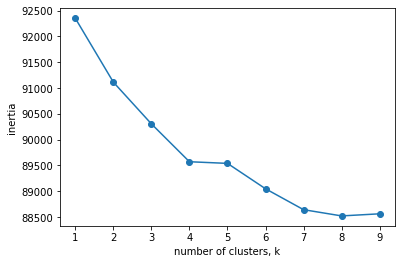

In [ ]:
import matplotlib.pyplot as plt
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(cv_matrix)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [ ]:
NUM_CLUSTERS = 8
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=1000, n_init=50, random_state=42).fit(cv_matrix)
print(km.labels_)

[2 2 7 ... 1 7 7]


## Cluster Based on Numeric Vars

In [ ]:
dfReviewOverlap  = overlap[['title','year','duration','avg_vote']]
dfReviewOverlap.set_index('title', drop = True, inplace = True)
dfReviewOverlap.head()

In [ ]:
dfReviewOverlap.loc['Bad Education', 'year'] = '2019'
dfReviewOverlap['year'] = dfReviewOverlap['year'].astype('int')

/Applications/anaconda3/envs/Python38env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-13-94c0d135d05f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfReviewOverlap['year'] = dfReviewOverlap['year'].astype('int')


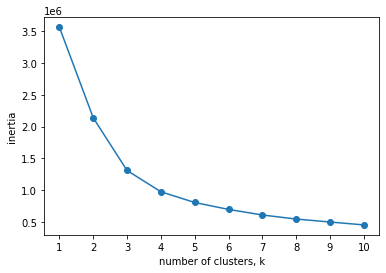

In [ ]:
import matplotlib.pyplot as plt
ks = range(1, 11)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(dfReviewOverlap)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [ ]:
NUM_CLUSTERS = 3
kmNumeric = KMeans(n_clusters=NUM_CLUSTERS, max_iter=1000, n_init=50, random_state=42).fit(dfReviewOverlap)
print(kmNumeric.labels_)

[0 0 0 ... 1 1 1]


In [ ]:
dfReviewOverlap

,year,duration,avg_vote
title,,,
Cleopatra,1912,100,5.2
Richard III,1912,55,5.5
Atlantis,1913,121,6.6
Cabiria,1914,148,7.1
Cinderella,1914,52,6.0
...,...,...,...
S.W.A.T.,2019,109,4.2
Solo mia,2019,87,4.7
The Driver,2019,97,4.0


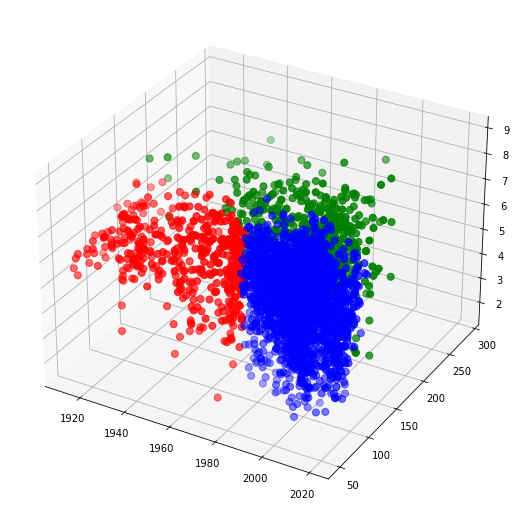

In [ ]:
# Import pyplot
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assign the columns of new_points: xs and ys
x = dfReviewOverlap.values
y_kmeans = kmNumeric.fit_predict(x)
fig = plt.figure(figsize=(15,7))
ax = Axes3D(fig)

#Visualising the clusters
ax.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 1], x[y_kmeans == 0, 2], s = 50, 
            c = 'red', label = 'group1')
ax.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 1], x[y_kmeans == 1, 2],s = 50, 
            c = 'blue', label = 'group2')
ax.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 1], x[y_kmeans == 2, 2],s = 50, 
            c = 'green', label = 'group3')


In [ ]:
kClusterDf = pd.DataFrame()
km_labels = pd.DataFrame(km.labels_, columns = ['description'])
kmNumeric_labels = pd.DataFrame(kmNumeric.labels_, columns = ['numeric'])

kClusterDf = pd.concat([overlap['title'],km_labels,kmNumeric_labels], axis = 1)
kClusterDf.set_index('title', drop = True, inplace = True)
kClusterDf

,description,numeric
title,,
Cleopatra,2,0
Richard III,2,0
Atlantis,7,0
Cabiria,7,0
Cinderella,2,0
...,...,...
S.W.A.T.,7,1
Solo mia,2,1
The Driver,1,1


## Label Each Film

In [ ]:
def label_race (row):
    if row['numeric'] == 0:
        if row['description'] == 0:
            return 0
        elif row['description'] == 1:
            return 1
        elif row['description'] == 2:  
            return 2
        elif row['description'] == 3: 
            return 3
        elif row['description'] == 4:  
            return 4
        elif row['description'] == 5:  
            return 5
        elif row['description'] == 6:  
            return 6
        elif row['description'] == 7:  
            return 7
    if row['numeric'] == 1:
        if row['description'] == 0:
            return 8
        elif row['description'] == 1:
            return 9
        elif row['description'] == 2:  
            return 10
        elif row['description'] == 3: 
            return 11
        elif row['description'] == 4:  
            return 12
        elif row['description'] == 5:  
            return 13
        elif row['description'] == 6:  
            return 14
        elif row['description'] == 7:  
            return 15
    if row['numeric'] == 2:
        if row['description'] == 0:
            return 16
        elif row['description'] == 1:
            return 17
        elif row['description'] == 2:  
            return 18
        elif row['description'] == 3: 
            return 19
        elif row['description'] == 4:  
            return 20
        elif row['description'] == 5:  
            return 21
        elif row['description'] == 6:  
            return 22
        elif row['description'] == 7:  
            return 23

In [ ]:
cluster = kClusterDf.apply (lambda row: label_race(row), axis=1)

In [ ]:
kClusterDf = pd.concat([kClusterDf, pd.DataFrame(cluster, columns = ['cluster'])], axis = 1)
kClusterDf

,description,numeric,cluster
title,,,
Cleopatra,2,0,2
Richard III,2,0,2
Atlantis,7,0,7
Cabiria,7,0,7
Cinderella,2,0,2
...,...,...,...
S.W.A.T.,7,1,15
Solo mia,2,1,10
The Driver,1,1,9


In [ ]:
bagOfWords = pd.DataFrame(dfMovieOverlap['bag_of_words'])
labels = pd.DataFrame(km.labels_)
labels['title'] = overlap['title']
labels.set_index('title', inplace = True)
df_new = pd.concat([bagOfWords, pd.DataFrame(cluster, columns = ['cluster'])], axis = 1)
df_new.columns = ['bag_of_words', 'cluster']
df_new

,bag_of_words,cluster
title,,
Cleopatra,cleopatra drama history usa english charlesl....,2
Richard III,richard iii drama france usa english andrécal...,2
Atlantis,atlantis drama denmark danish augustblom olaff...,7
Cabiria,cabiria adventure drama history italy italia...,7
Cinderella,cinderella drama fantasy usa english jameskir...,2
...,...,...
S.W.A.T.,s.w.a.t. action china mandarin shengding xiao-...,15
Solo mia,solo mia drama thriller usa english michaelci...,10
The Driver,the driver action horror thailand english wyc...,9


In [ ]:
resList = dict()
for i in range(1,24):
# instantiating and generating the count matrix
    count = CountVectorizer()
    count_matrix = count.fit_transform(df_new[df_new['cluster'] == i]['bag_of_words'])

# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use later to match the indexes
    indices = pd.Series(df_new[df_new['cluster'] == i].index)

    cosine_sim = cosine_similarity(count_matrix, count_matrix)
    resList[i] = cosine_sim

print(resList)

{1: array([[1.        , 0.07658396, 0.03456506, ..., 0.0352235 , 0.03080206,
        0.        ],
       [0.07658396, 1.        , 0.0410305 , ..., 0.0418121 , 0.10969086,
        0.1081125 ],
       [0.03456506, 0.0410305 , 1.        , ..., 0.1132277 , 0.06600984,
        0.03253   ],
       ...,
       [0.0352235 , 0.0418121 , 0.1132277 , ..., 1.        , 0.10090092,
        0.06629935],
       [0.03080206, 0.10969086, 0.06600984, ..., 0.10090092, 1.        ,
        0.11595421],
       [0.        , 0.1081125 , 0.03253   , ..., 0.06629935, 0.11595421,
        1.        ]]), 2: array([[1.        , 0.18650096, 0.13693064, ..., 0.1204829 , 0.12456822,
        0.10540926],
       [0.18650096, 1.        , 0.17025131, ..., 0.14980118, 0.15488062,
        0.14744196],
       [0.13693064, 0.17025131, 1.        , ..., 0.10998534, 0.11371471,
        0.14433757],
       ...,
       [0.1204829 , 0.14980118, 0.10998534, ..., 1.        , 0.13340747,
        0.08466675],
       [0.12456822, 0.15488

In [ ]:
# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use in the function to match the indexes
indices = pd.Series(df_new.index)

#  defining the function that takes in movie title 
# as input and returns the top recommended movies
def recommendations(title, n, cosine_sim = cosine_sim):
    
    # initializing the empty list of recommended movies
    recommended_movies = []
    
    # get the curCluster
    clusterNo = df_new.loc[title]['cluster']
    df_curCluster = df_new[df_new['cluster'] == clusterNo]
    indices = pd.Series(df_curCluster.index)
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]
    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:n].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(df_curCluster.index)[i])
        
    return recommended_movies

In [ ]:
recommendations('Richard III', 20)

['Dragstrip Girl',
 'Julius Caesar',
 'The Girl on the Bridge',
 'Madame Butterfly',
 'Fear',
 'Trapped',
 'Texas',
 "Winchester '73",
 'Fantasia',
 'Male and Female',
 'Maya',
 'The Fast and the Furious',
 'Cover Up',
 'Vendetta',
 'Kim',
 'Dumbo',
 'Il grido',
 'Rebound',
 'Jealousy']

In [ ]:
clusterNo = df_new.loc['Atlantis']['cluster']
df_curCluster = df_new[df_new['cluster'] == clusterNo]
df_curCluster

,bag_of_words,cluster
title,,
Atlantis,atlantis drama denmark danish augustblom olaff...,7
Cabiria,cabiria adventure drama history italy italia...,7
Harakiri,harakiri drama germany dutch fritzlang paulbie...,7
Othello,othello drama romance germany german dimitrib...,7
Aelita,aelita adventure comedy drama soviet union r...,7
...,...,...
School of the Holy Beast,school of the holy beast drama thriller japan...,7
Female Prisoner #701: Scorpion,female prisoner #701: scorpion crime drama t...,7
Love After Death,love after death crime drama horror argentin...,7


In [ ]:
recommendations('Atlantis', 20, resList[df_new.loc['Atlantis']['cluster']])

['Fame',
 'Forbidden',
 'Elvira Madigan',
 'Teorema',
 'Borderline',
 'Sebastiane',
 'The Deep',
 'La promesse',
 'Rat',
 'Les carabiniers',
 'Love After Death',
 'Kanal',
 'It Happened Here',
 'Il posto',
 "Gentleman's Agreement",
 'Umberto D.',
 'Michael',
 'Alfie',
 'Bartleby']

In [ ]:
netRating = pd.read_csv('rating_imdb_subset.csv')

In [ ]:
# find users who have given a 5 to 20 or more movies that's overlapping
rating_content_based = netRating
good_ratings_content_based = rating_content_based[rating_content_based['rating']==5]
len(good_ratings_content_based)
good_rating_gby_user = good_ratings_content_based.groupby('user_id')['movie_id'].count()
user_5 = good_rating_gby_user[good_rating_gby_user >= 20].index

# get the 5 ratings of these users
rating_user5 = good_ratings_content_based[good_ratings_content_based['user_id'].isin(user_5)]
rating_user5.sort_values('user_id', inplace=True)

<ipython-input-32-73c028dfe8d2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_user5.sort_values('user_id', inplace=True)


In [ ]:
# get single id who watches Ciderella (movie_id = 10051)
uniID = rating_user5[rating_user5['rating'] == 5][rating_user5['movie_id'] == 10051].user_id.unique()
uniID[0:10]

array([ 3363,  6701, 23178, 25483, 30087, 46003, 49890, 51817, 71426,
       73103])

In [ ]:
# see how many movies one single user watch
groupByUser = rating_user5.groupby(['user_id']).count()
groupByUser

,movie_id,rating
user_id,,
7,68,68
59,20,20
79,35,35
97,31,31
134,164,164
...,...,...
2649308,39,39
2649331,27,27
2649335,33,33


In [ ]:
# for every user 
resDf = pd.DataFrame()
for i in uniID:
    # find movielist for each user
    movieList = netRating[netRating['user_id'] == i]
    # create a new df which will contain the movie title(which we find out based on netflix_movie_id in IMDB dataset)
    nameDf = pd.DataFrame()
    for i in movieList['movie_id']:
        name = overlap[overlap['netflix_movie_id'] == i]['title']
        name = pd.DataFrame(name)
        nameDf = nameDf.append(name)
    resDf = pd.concat([resDf, nameDf],ignore_index=True, axis=1)

In [ ]:
resDf.head()

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,300,301,302,303
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Cleopatra,NaN,NaN,NaN,NaN,Cleopatra,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,Richard III,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,...,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella


In [ ]:
resDf.columns = uniID
resDf

,3363,6701,23178,25483,30087,46003,49890,51817,71426,73103,...,2587314,2599377,2600558,2607302,2625561,2629402,2634456,2634610,2635140,2635943
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Cleopatra,NaN,NaN,NaN,NaN,Cleopatra,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,Richard III,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,...,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668,NaN,NaN,NaN,NaN,NaN,NaN,S.W.A.T.,NaN,S.W.A.T.,NaN,...,NaN,S.W.A.T.,S.W.A.T.,NaN,S.W.A.T.,S.W.A.T.,NaN,NaN,S.W.A.T.,NaN
3669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# find out overlapping of users' movielist and our recommendation list
nestedList = []
precision = []
recall = []
for i in range(0,304):
    userMovieList = resDf.iloc[:,i].dropna().values  
    temp = []
    uid = uniID[i]
    recomList = recommendations('Cinderella',groupByUser.loc[[uid]]['movie_id'].values[0])
    for i in recomList:
        if i in userMovieList:
            temp.append(i)
    curPrecision = len(temp)/len(recomList)
    precision.append(curPrecision)
    
    curRecall = len(temp)/len(userMovieList)
    recall.append(curRecall)
    nestedList.append(temp)
nestedList[0:10]

0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, dtype: object
0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, dtype: object
0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, dtype: object
0               Cleopatra

Name: title, Length: 92, dtype: object
0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, dtype: object
0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, dtype: object
0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, 

Name: title, Length: 92, dtype: object
0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, dtype: object
0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, dtype: object
0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, 

Name: title, Length: 92, dtype: object
0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, dtype: object
0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, dtype: object
0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, 

Name: title, Length: 92, dtype: object
0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, dtype: object
0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, dtype: object
0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, 

Name: title, Length: 92, dtype: object
0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, dtype: object
0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, dtype: object
0               Cleopatra
1             Richard III
2              Cinderella
3     Alice in Wonderland
4         Sherlock Holmes
             ...         
87           Best Friends
88                 Joshua
89          The Foreigner
90          The Hard Road
91             Thumbelina
Name: title, Length: 92, 

[['Dumbo', 'Trapped', 'Fantasia', 'Dracula', 'M', 'Glory'],
 [],
 [],
 [],
 ['Dumbo',
  'The Last of the Mohicans',
  'Law and Order',
  'The Fast and the Furious',
  'Braveheart'],
 ['Dumbo', 'Fantasia'],
 ['Dumbo',
  'Macbeth',
  'Fantasia',
  'No Escape',
  'Richard III',
  'A Christmas Carol',
  'Freaks',
  'Fear',
  'Dracula',
  'M',
  'The Last of the Mohicans',
  'The Fast and the Furious',
  'Braveheart',
  'The Woman in Red',
  'Glory'],
 ['Dumbo'],
 ['Trapped', 'Fantasia', 'Fear', 'The Fast and the Furious', 'Glory'],
 ['Rebound', 'Trapped', 'Bait', 'Fear', 'Tumbleweeds']]

In [ ]:
# overlapping result
nestedList[0:5]

[['Dumbo', 'Trapped', 'Fantasia', 'Dracula', 'M', 'Glory'],
 [],
 [],
 [],
 ['Dumbo',
  'The Last of the Mohicans',
  'Law and Order',
  'The Fast and the Furious',
  'Braveheart']]

In [ ]:
precision[0:10]

[0.12280701754385964,
 0.04827586206896552,
 0.012987012987012988,
 0.07162534435261708,
 0.027777777777777776,
 0.03875968992248062,
 0.04245283018867924,
 0.11873350923482849,
 0.0481283422459893,
 0.1402805611222445]

In [ ]:
sum(precision)/len(precision)

0.05633211227675357

In [ ]:
recall[0:10]

[0.07349081364829396,
 0.022435897435897436,
 0.011111111111111112,
 0.05273833671399594,
 0.022988505747126436,
 0.025,
 0.030612244897959183,
 0.05344418052256532,
 0.045,
 0.09271523178807947]

In [ ]:
sum(recall)/len(recall)

0.013125951212701542

## Improvement

In [ ]:
# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use in the function to match the indexes
indices = pd.Series(df_new.index)

#  defining the function that takes in movie title 
# as input and returns the top recommended movies
def recommendations2(title1, title2, title3, n):
    
    # initializing the empty list of recommended movies
    recommended_movies = []
    
    # get the curCluster
    clusterNo1 = df_new.loc[title1]['cluster']
    df_curCluster1 = df_new[df_new['cluster'] == clusterNo1]
    indices1 = pd.Series(df_curCluster1.index)
    
    clusterNo2 = df_new.loc[title2]['cluster']
    df_curCluster2 = df_new[df_new['cluster'] == clusterNo2]
    indices2 = pd.Series(df_curCluster2.index)
    
    clusterNo3 = df_new.loc[title3]['cluster']
    df_curCluster3 = df_new[df_new['cluster'] == clusterNo3]
    indices3 = pd.Series(df_curCluster3.index)
    
    df_curCluster = pd.concat([df_curCluster1, df_curCluster2, df_curCluster3], axis = 0)
    
    # gettin the index of the movie that matches the title
    idx1 = indices1[indices1 == title1].index[0]
    idx2 = indices2[indices2 == title2].index[0]
    idx3 = indices3[indices3 == title3].index[0]
    
    # creating a Series with the similarity scores in descending order
    cosine_sim1 = resList[clusterNo1]
    score_series1 = pd.Series(cosine_sim1[idx1]).sort_values(ascending = False)
    
    cosine_sim2 = resList[clusterNo2]
    score_series2 = pd.Series(cosine_sim2[idx2]).sort_values(ascending = False)

    cosine_sim3 = resList[clusterNo3]
    score_series3 = pd.Series(cosine_sim2[idx3]).sort_values(ascending = False)
    
    score_series = pd.concat([score_series1, score_series2, score_series3], axis = 0)
    score_series = score_series.reset_index(drop = True)
    # getting the indexes of the 10 most similar movies
    if n > 500:
        n = 500
    top_10_indexes = list(score_series.iloc[1:n].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(df_curCluster.index)[i])
        
    return recommended_movies

In [ ]:
# Example
recommendations2('Cinderella', 'S.W.A.T.','The King and I', 20)

['Richard III',
 'Cinderella',
 'Alice in Wonderland',
 'Sherlock Holmes',
 'Male and Female',
 'Humoresque',
 'The Last of the Mohicans',
 'Sex',
 'Oliver Twist',
 'Shadows',
 'Body and Soul',
 'Braveheart',
 'Stella Dallas',
 'Tumbleweeds',
 'Beau Geste',
 'The Show',
 'The Letter',
 'Dracula',
 'Rebound']

In [ ]:
# get single id who watches Ciderella (movie_id = 10051)  and S.W.A.T. (1307) and the King and I (4135)
uniID = rating_user5[rating_user5['movie_id'] == 10051]
uniID = pd.concat([uniID, rating_user5[rating_user5['movie_id'] == 1307], rating_user5[rating_user5['movie_id'] == 4135]], axis = 0)
#uniID = uniID.user_id.unique()
uniID = uniID.groupby('user_id')['movie_id'].count()
user_both = uniID[uniID >= 3].index
#uniID

In [ ]:
user_both

Int64Index([  49890,   71426,  284660,  285975,  499914,  613753,  651629,
             743633,  811704, 1117152, 1161725, 1670875, 1777158, 2030523,
            2228763, 2238060, 2432433, 2463441, 2491249, 2531429, 2600558],
           dtype='int64', name='user_id')

In [ ]:
# for every user 
resDf = pd.DataFrame()
for i in user_both:
    # find movielist for each user
    movieList = netRating[netRating['user_id'] == i]
    # create a new df which will contain the movie title(which we find out based on netflix_movie_id in IMDB dataset)
    nameDf = pd.DataFrame()
    for i in movieList['movie_id']:
        name = overlap[overlap['netflix_movie_id'] == i]['title']
        name = pd.DataFrame(name)
        nameDf = nameDf.append(name)
    resDf = pd.concat([resDf, nameDf],ignore_index=True, axis=1)

In [ ]:
resDf.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cleopatra,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cleopatra
1,Richard III,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Richard III,NaN,NaN,NaN,NaN,NaN
4,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,...,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella,Cinderella
11,Snow White,NaN,Snow White,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Snow White,NaN,Snow White,NaN,NaN,Snow White
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The Little Princess,NaN,...,NaN,NaN,The Little Princess,The Little Princess,The Little Princess,NaN,The Little Princess,NaN,NaN,The Little Princess


In [ ]:
# find out overlapping of users' movielist and our recommendation list
nestedList = []
precision = []
recall = []
for i in range(0,20):
    userMovieList = resDf.iloc[:,i].dropna().values  
    temp = []
    uid = user_both[i]
    recomList = recommendations2('Cinderella', 'S.W.A.T.', 'The King and I', groupByUser.loc[[uid]]['movie_id'].values[0])
    for i in recomList:
        if i in userMovieList:
            temp.append(i)
    curPrecision = len(temp)/len(recomList)
    precision.append(curPrecision)
    
    curRecall = len(temp)/len(userMovieList)
    recall.append(curRecall)
    nestedList.append(temp)

In [ ]:
sum(precision)/len(precision)

0.08206375392380003

In [ ]:
sum(recall)/len(recall)

0.042176555464580046